In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

version_id = 'v2'
SEED = 42

Using TensorFlow backend.


In [2]:
# get h5 datasets
data_path = "data/background/*_data.h5"
signal_path = "data/signal/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.15

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(train_raw, **norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.2% (2852) train
	3.2% (489) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (32891) train
	38.4% (5950) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.3% (16108) train
	18.6% (2891) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.7% (21690) train
	23.8% (3687) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.3% (8159) train
	9.1% (1418) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.1% (6203) train
	6.9% (1078) test
	7.0% (7281) background
	5.1% (2541) signal


data_table :: plotting distrubution(s) for table(s) ['jet 0 background', 'jet 1 background', 'jet 0 signal', 'jet 1 signal']


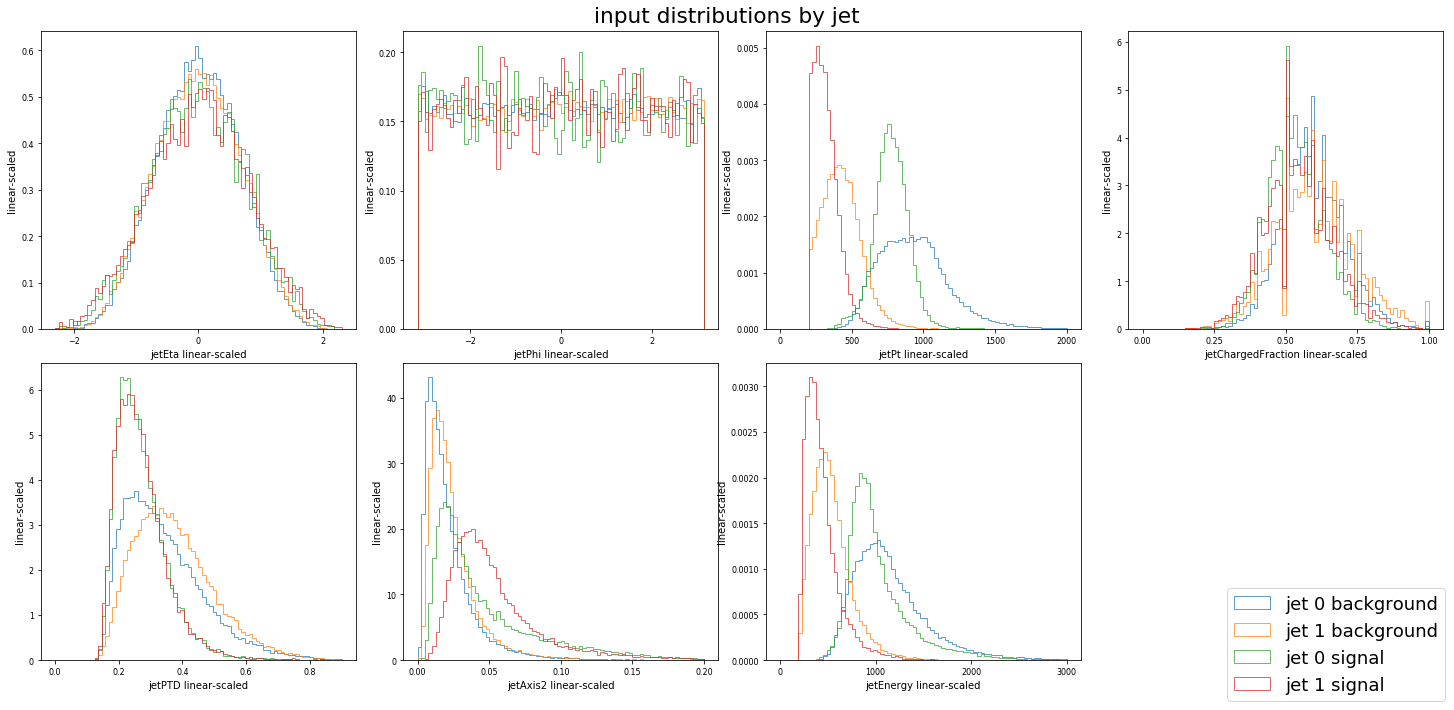

In [3]:
data_jets_raw = [d.cfilter(data_raw.headers) for d in data_jets]
signal_jets_raw = [d.cfilter(data_raw.headers) for d in signal_jets]

data_jets_raw[0].plot(
    data_jets_raw[1:] + signal_jets_raw,
    normed=1, figname="input distributions by jet", 
    bins=80, figsize=20,
    rng=[(-2.3, 2.3), (-np.pi, np.pi), (0., 2000.), (0., 1.), (0., 0.9), (0., 0.2), (0, 3000)]
)

In [4]:
l1_amount = None          # l1 regularization amount
# KL_loss_weight = 1.8      # according to olmo's paper
input_dim = 7              # num. HLF
interm_dim = 20            # num. interm nodes
neck_dim = 2             # num. latent variables
kernel_max_norm = None     # kernel max norm amount
learning_rate = 0.0001

name = "custom_loss_{0}_{1}".format(neck_dim, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/"

In [5]:
ae_skeleton = models.base_autoencoder()
ae_skeleton.add(input_dim)
ae_skeleton.add(interm_dim)
ae_skeleton.add(interm_dim)
ae_skeleton.add(neck_dim, 'relu')
ae_skeleton.add(interm_dim)
ae_skeleton.add(interm_dim)
ae_skeleton.add(input_dim, "linear")

autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 2)                 622       
_________________________________________________________________
decoder (Model)              (None, 7)                 627       
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [6]:
instance = trainer.trainer(os.path.join(model_path, name))

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'custom_loss_2_v2.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'custom_loss_2_v2.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'custom_loss_2_v2.h5'
h5_elt 'val_r_square' :: loading dataset 'metric_names/val_r_square' from file 'custom_loss_2_v2.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'custom_loss_2_v2.h5'
h5_elt 'mean_absolute_error' :: loading dataset 'metric_names/mean_absolute_error' from file 'custom_loss_2_v2.h5'
h5_elt 'val_mean_squared_error' :: loading dataset 'metric_names/val_mean_squared_error' from file 'custom_loss_2_v2.h5'
h5_elt 'val_mean_absolute_error' :: loading dataset 'metric_names/val_mean_absolute_error' from file 'custom_loss_2_v2.h5'
h5_elt 'r_square' :: loading dataset 'metric_names/r_square' from file 'custom_loss_2_v2.h5'
h5_elt 'mean_squared_error' :: loading dataset 'metric_names/mean_squared_error' from file 'custom_

In [7]:
autoencoder = instance.load_model()

train_shell :: using saved model


In [8]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

train = False
if train:
    autoencoder = instance.train(
        x_train=train_norm.data,
        x_test=test_norm.data,
        y_train=train_norm.data,
        y_test=test_norm.data,
        optimizer="adam",
        loss='mse',
        epochs=200,
        model=autoencoder,
        metrics=[r_square, "mae", "mse"],
        force=True,
        batch_size=128,
        use_callbacks=True,
        learning_rate=0.005
    )

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

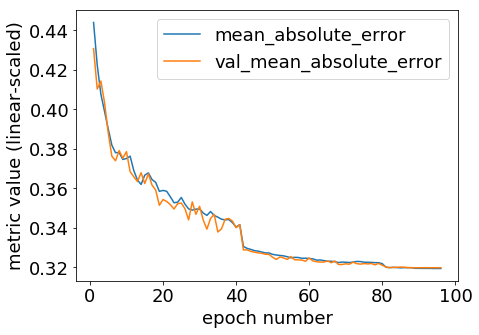

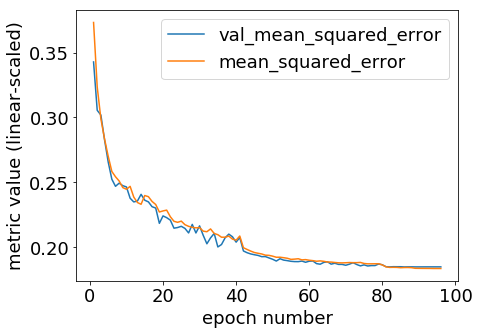

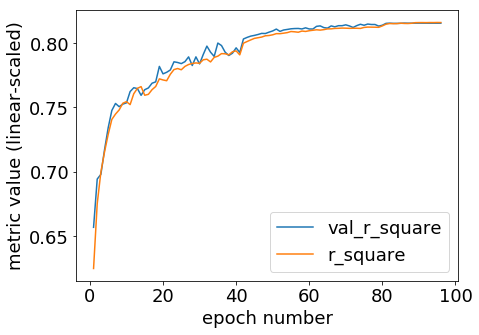

In [9]:
# instance.plot_metrics(fnmatch_criteria="*loss*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [10]:

errors, recon = utils.get_recon_errors(
    [train_norm, test_norm, data_norm, signal_norm],
    autoencoder, functions=['mse', 'mae'],
    names=[None, None]
)

(train_err, test_err, data_err, signal_err) = errors
(train_recon, test_recon, data_recon, signal_recon) = recon


signal_jets_norm, data_jets_norm = [
    [train_raw.norm(j.cfilter(signal_norm.headers), **norm_args) for j in jet_table] for jet_table in [signal_jets, data_jets]
]

In [11]:
encoder, decoder = autoencoder.layers[1:]

nodenames = ["node {}".format(i+1) for i in range(neck_dim)]

data_reps, signal_reps = (
    utils.data_table(encoder.predict(data_norm.data), headers=nodenames, name="background_reps"),
    utils.data_table(encoder.predict(signal_norm.data), headers=nodenames, name="signal_reps")
)

data_jet_reps, signal_jet_reps = (
    [utils.data_table(encoder.predict(d.data), headers=nodenames, name="jet {} background reps".format(i)) for i,d in enumerate(data_jets_norm)],
    [utils.data_table(encoder.predict(d.data), headers=nodenames, name="jet {} signal reps".format(i)) for i,d in enumerate(signal_jets_norm)],
)

data_table :: plotting distrubution(s) for table(s) ['background_reps', 'signal_reps']


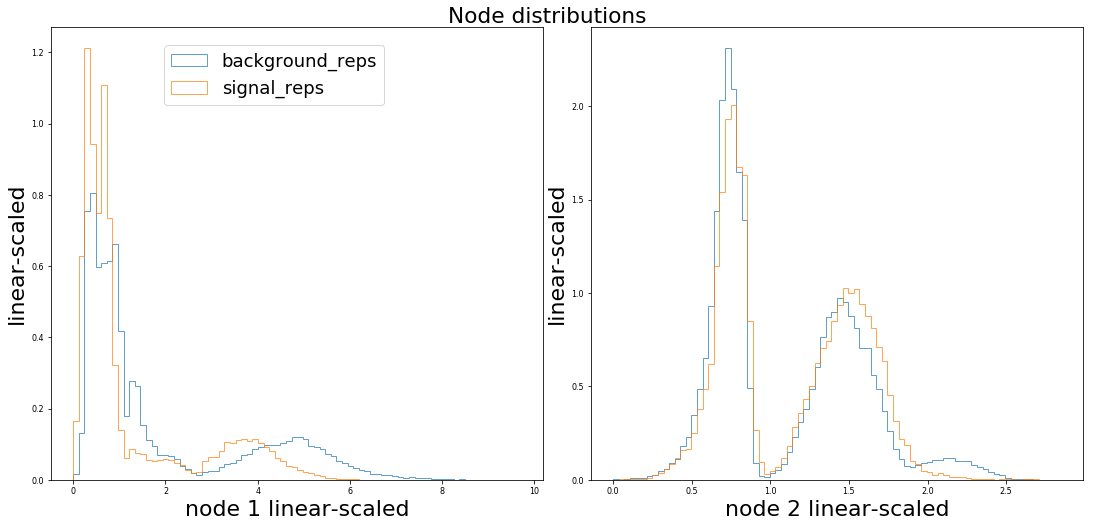

data_table :: plotting distrubution(s) for table(s) ['jet 0 background reps', 'jet 1 background reps', 'jet 0 signal reps', 'jet 1 signal reps']


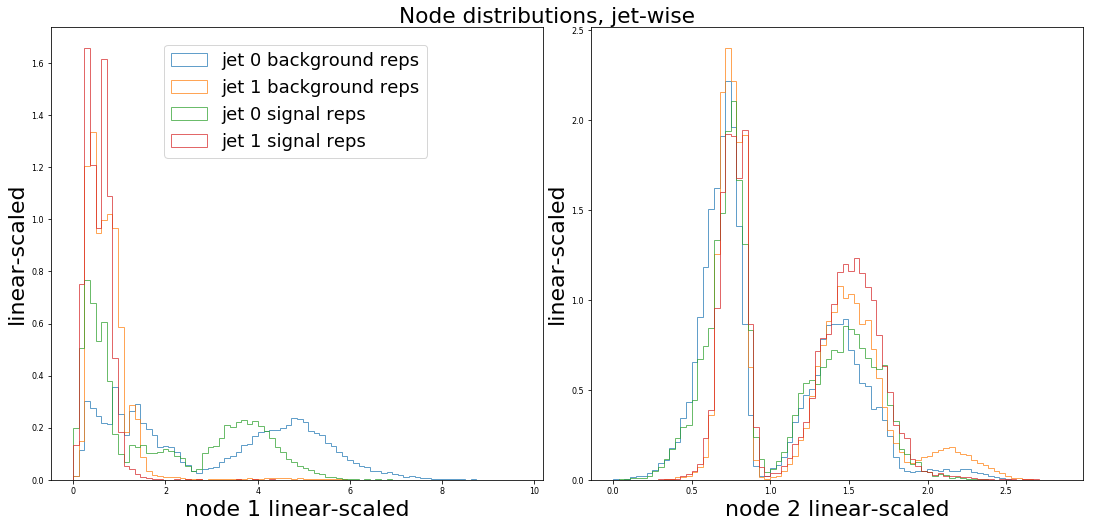

In [12]:
data_reps.plot([signal_reps], cols=5, figsize=15, fontsize=22, normed=1, bins=80, figname="Node distributions", figloc=(0.15,0.8))
data_jet_reps[0].plot(data_jet_reps[1:] + signal_jet_reps, cols=5, figsize=15, fontsize=22, normed=1, bins=80, figname="Node distributions, jet-wise", figloc=(0.15,0.7))

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train'", "'background' normed to 'train' pred"]


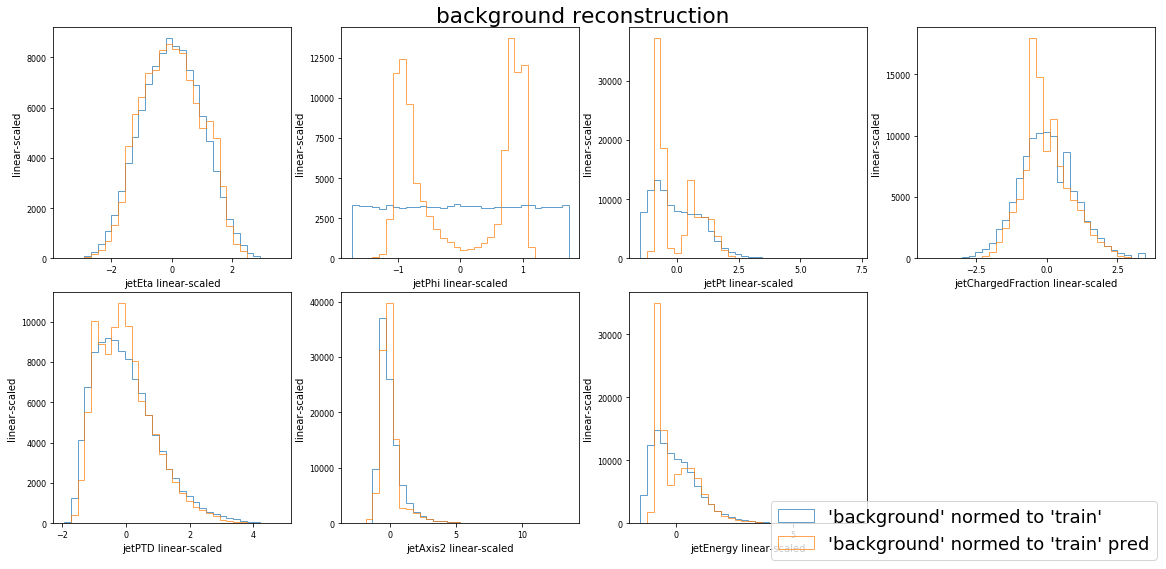

data_table :: plotting distrubution(s) for table(s) ["'signal' normed to 'train'", "'signal' normed to 'train' pred"]


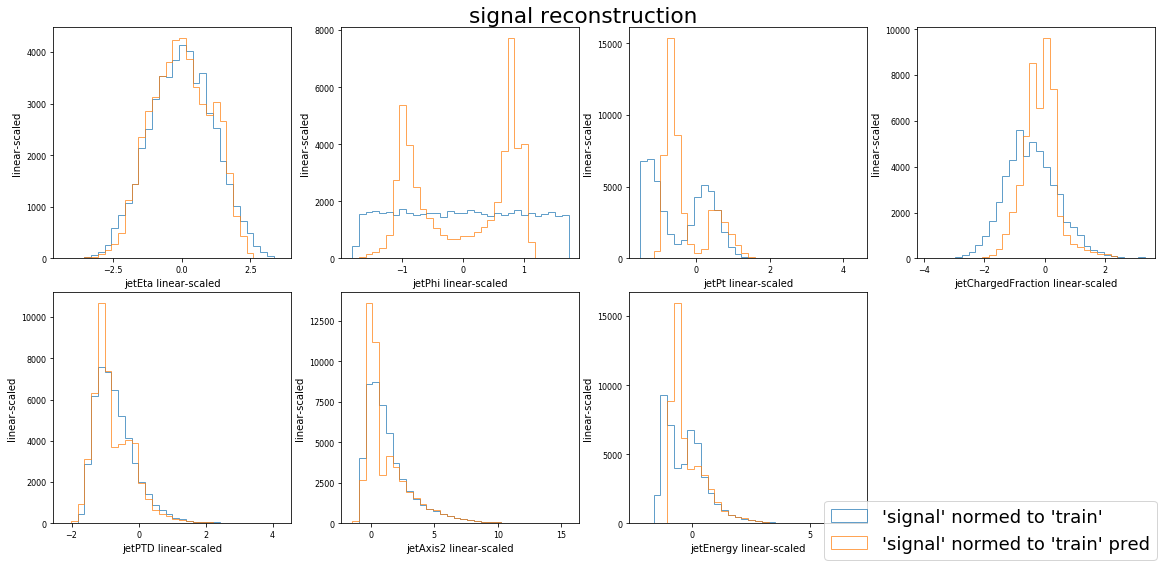

In [13]:
data_norm.plot(data_recon, normed=0, figname="background reconstruction")
signal_norm.plot(signal_recon, normed=0, figname="signal reconstruction")

In [14]:
data_jets_recon = [autoencoder.predict(j.data) for j in data_jets_norm]
signal_jets_recon = [autoencoder.predict(j.data) for j in signal_jets_norm]

err_data_jets = [
    utils.get_errors(
        true, pred, 
        out_name="jet {} background error".format(i),
        functions=['mae', 'mse']
    ) for i,(true,pred) in enumerate(zip(data_jets_norm, data_jets_recon))
]

err_signal_jets = [
    utils.get_errors(
        true, pred, 
        out_name="jet {} signal error".format(i),
        functions=['mae', 'mse']
    ) for i,(true,pred) in enumerate(zip(signal_jets_norm, signal_jets_recon))
]

data_table :: plotting distrubution(s) for table(s) ['jet 0 signal error', 'jet 1 signal error', 'jet 0 background error', 'jet 1 background error']


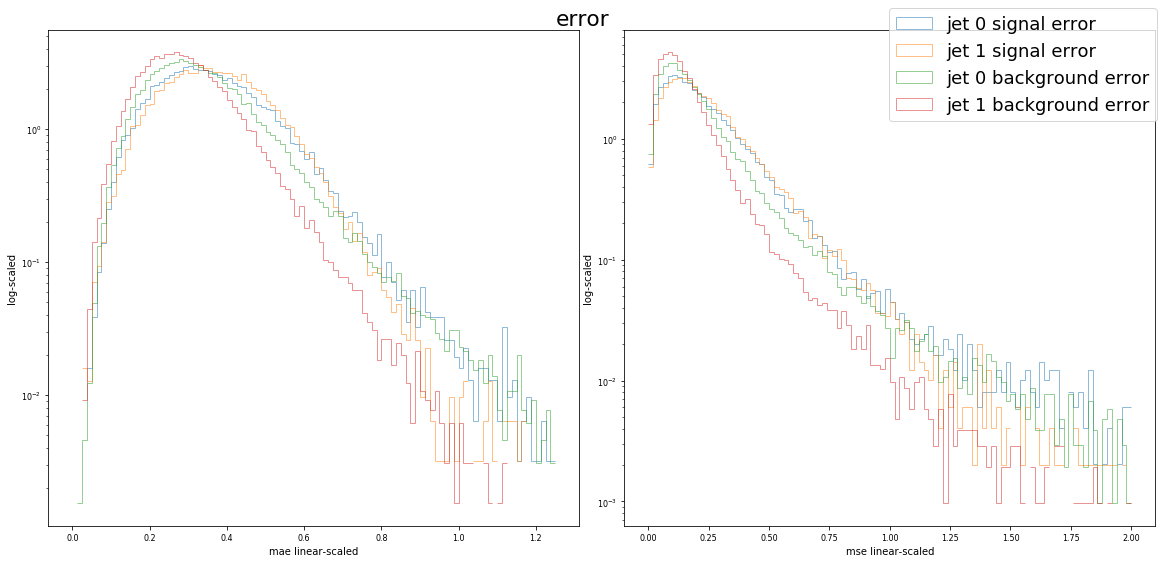

In [15]:
err_signal_jets[0].plot(
    err_signal_jets[1:] + err_data_jets, bins=100, normed=1, yscale='log',
    figsize=16, alpha=1.5, figloc="upper right", cols=2, rng=((0,1.25), (0,2.)),
    figname="error"
)

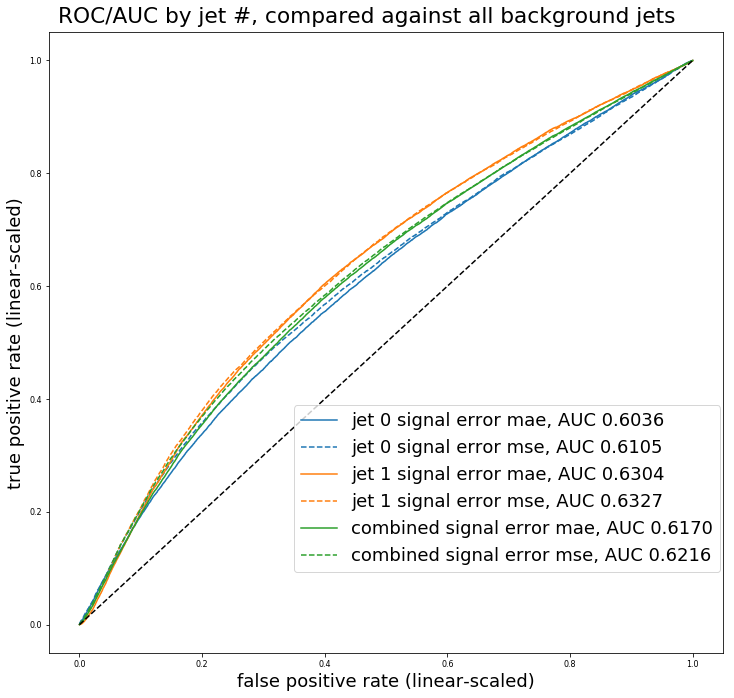

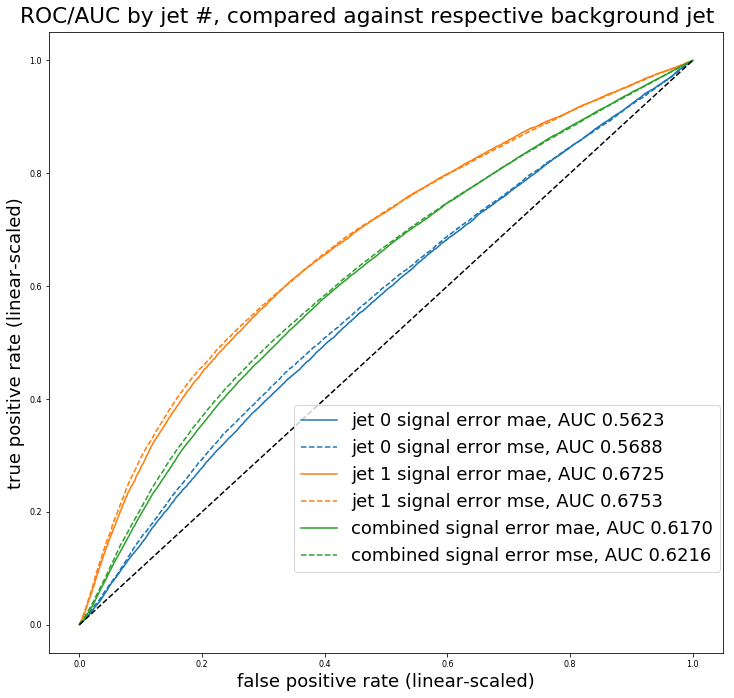

In [23]:
data_err.name = "combined background error"
signal_err.name = "combined signal error"

utils.roc_auc_plot(
    [data_err], err_signal_jets + [signal_err],
    metrics=err_data_jets[0].headers, figsize=10, figloc=(.4,.18),
    figname="ROC/AUC by jet #, compared against all background jets"
)

utils.roc_auc_plot(
    err_data_jets + [data_err], err_signal_jets + [signal_err],
    metrics=err_data_jets[0].headers, figsize=10, figloc=(.4,.18),
    figname="ROC/AUC by jet #, compared against respective background jet"
)



# utils.roc_auc_plot(
#     [data_err], err_signal_jets + [signal_err], 
#     ticksize=10, yscale='linear', figsize=10, figloc=(.4, .10), 
#     figname="ROC by jet #, compared against all background jets",
#      metrics=err_data_jets[0].headers,
# )
# utils.roc_auc_plot(
#     err_data_jets + [data_err], err_signal_jets + [signal-err],
#     ticksize=10, yscale='linear', figsize=10, figloc=(.4, .10),
#     figname="ROC by jet #, compared against respective background jet",
#      metrics=err_data_jets[0].headers,
# )